In [ ]:
# 多组测试数据相关性表现：[1.0, 1.0, 1.0]

In [1]:
# 设定所有月份的oneminute数据经过factor_pycode处理后将要保存的位置

######################################################################### factor_result_allmonth路径替换
output_directory = r'F:\QuantData\factor_result_allmonth\factor_35_RSkew'
######################################################################### factor_result_allmonth路径替换

In [4]:
# 定义函数get_factor.给定分钟数据，返回形如'SecuCode''TradeDay'因子值三列的结果数据
# 取自 20035_1.py
import pandas as pd
import numpy as np

def get_factor(data):
    ################################################################################################# factor_pycode代码替换
    # 计算对数收益率
    data['LogReturn'] = np.log(data['ClosePrice'] / data['PreClosePrice'])
    
    # 计算平均对数收益率
    data['AvgLogReturn'] = data.groupby(['SecuCode', 'TradeDay'])['LogReturn'].transform('mean')
    
    # 计算已实现波动率
    data['SquaredDiff'] = (data['LogReturn'] - data['AvgLogReturn']) ** 2
    data['RVar'] = data.groupby(['SecuCode', 'TradeDay'])['SquaredDiff'].transform('sum')
    
    # 计算收益率偏差的三次方之和
    data['CubedDiff'] = (data['LogReturn'] - data['AvgLogReturn']) ** 3
    data['SumCubedDiff'] = data.groupby(['SecuCode', 'TradeDay'])['CubedDiff'].transform('sum')
    
    # 计算高频已实现偏度
    data['N'] = data.groupby(['SecuCode', 'TradeDay'])['LogReturn'].transform('count')
    data['RSkew'] = np.sqrt(data['N']) * data['SumCubedDiff'] / (data['RVar'] ** (3 / 2))
    
    # 提取所需列
    result = data[['SecuCode', 'TradeDay', 'RSkew']].drop_duplicates()
    
    # result = result.reset_index(drop=True)
    ################################ factor_pycode代码替换

    
    ############################################################### result结果数据表命名替换  &  因子列命名替换    
    result.rename(columns={'RSkew': 'FactorValue'}, inplace=True)
    ############################################################### result结果数据表命名替换  &  因子列命名替换    
    
    ################ result结果数据表命名替换
    return result
    ################ result结果数据表命名替换 

In [5]:
# 导入所有one_minute文件，生成相对应factor_result文件，并保存（每个文件对应某年某月）

import pandas as pd
import os

def generate_factor_files(input_directory, output_directory, process_function, start_year, start_month, end_year, end_month):
    # 生成所有的文件名，按年月顺序
    input_file_names = []

    # 生成文件名列表，考虑到起始年月和结束年月的数据
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if (year == start_year and month < start_month) or (year == end_year and month > end_month):
                continue
            file_name = f"{year}{str(month).zfill(2)}_oneminute.feather"
            input_file_names.append(file_name)

    # 创建输出目录（如果不存在）
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # 处理并保存数据
    for file in input_file_names:
        input_file_path = os.path.join(input_directory, file)
        if os.path.exists(input_file_path):  # 检查文件是否存在
            # 读取Feather文件
            df_oneminute = pd.read_feather(input_file_path)
            
            # 调用数据处理函数
            df_res = process_function(df_oneminute)
            
            # 定义输出文件名
            year_month = file[:6]  # 提取文件名前6个字符作为年月
            output_file_name = f"{year_month}_factor_result.feather"
            output_file_path = os.path.join(output_directory, output_file_name)
            
            # 保存处理后的DataFrame为Feather文件
            df_res.to_feather(output_file_path)
            
            # print(f"Processed and saved {output_file_path}")
        else:
            print(f"File {file} does not exist.")

# one_minute数据存放的位置
input_directory = r'F:\QuantData\minute_data'

# 起始年月和结束年月（回测区间）
start_year, start_month = 2015, 1
end_year, end_month = 2024, 7

# 生成所有factor_result文件
generate_factor_files(input_directory, output_directory, get_factor, start_year, start_month, end_year, end_month)

In [2]:
# 每日高开低收数据df_Day_allmonth（201501-202407）把前面计算得到的factor_result数据全部整合进去

import pandas as pd
import numpy as np
import os

df_Day_allmonth = pd.read_feather('F:\\QuantData\\AShareEODPrices_allmonth.feather')

# 确保 TradeDay 列转换为日期时间格式
df_Day_allmonth['TradeDay'] = pd.to_datetime(df_Day_allmonth['TradeDay'])

output_file_names = [f for f in os.listdir(output_directory) if f.endswith('_factor_result.feather')]

# 先合并所有factor_result文件，再与df_Day_allmonth合并
list_res = []
for file in output_file_names:
    output_file_path = os.path.join(output_directory, file)
    
    # 读取Feather文件
    df_res = pd.read_feather(output_file_path)
    list_res.append(df_res)

df_factor_allmonth = pd.concat(list_res)

# 确保 TradeDay 列转换为日期时间格式
df_factor_allmonth['TradeDay'] = pd.to_datetime(df_factor_allmonth['TradeDay'])

# 与df_Day_allmonth合并
df_merge = pd.merge(df_factor_allmonth, df_Day_allmonth, on=['SecuCode', 'TradeDay'], how='left')


In [3]:
# 对每个交易日进行横截面市值中性化处理（消除市值对因子值的影响）

import statsmodels.api as sm

def neutralize_by_mv(df, factor):
    df = df.copy()
    df['logMV'] = np.log(df['TotalMV'].replace(0, np.nan))  # 避免log(0)带来的问题
    neutralized_values = []

    for date, group in df.groupby('TradeDay'):
        group = group.dropna(subset=[factor, 'logMV']).copy()  # 确保 group 是一个副本
        if group.empty:
            continue
        y = group[factor]
        X = sm.add_constant(group['logMV'])
        if len(X) > 1:  # 确保有足够的数据点进行回归
            model = sm.OLS(y, X).fit()
            group[factor + '_neu'] = model.resid
        else:
            group[factor + '_neu'] = np.nan
        neutralized_values.append(group)

    return pd.concat(neutralized_values)
    
# FactorValue经上述中性化操作得到FactorValue_neu
df_PT = neutralize_by_mv(df_merge, 'FactorValue')


In [4]:
# 将基于该因子值的十分组排名值赋回原来的数据表并导出，用于之后的多因子选股
import pandas as pd
import numpy as np

df_rank = df_PT.copy()

# 如果分组序号与因子值呈相反关系，则需要将因子值取负，从而得到倒置的分组序号(可根据后面的回测曲线得出)
df_rank['FactorValue_neu'] = -df_rank['FactorValue_neu']

# 自动分析回测区间的开始和结束日期
df_rank['TradeDay'] = pd.to_datetime(df_rank['TradeDay'])
start_date = df_rank['TradeDay'].min().strftime('%Y-%m')
end_date = df_rank['TradeDay'].max().strftime('%Y-%m')

# 计算每个月的末日
df_rank['Month'] = df_rank['TradeDay'].dt.to_period('M')
end_of_month = df_rank.groupby('Month')['TradeDay'].max().reset_index()

# 创建一个空的Series来保存所有的FactorValue_rank
df_rank['FactorValue_rank'] = np.nan

# 循环处理每个月的数据
for i in range(len(end_of_month) - 1):
    month_end_day = end_of_month.iloc[i]['TradeDay']

    # 获取该月最后一天的所有股票数据
    month_data = df_rank[df_rank['TradeDay'] == month_end_day].copy()
    
    # 对FactorValue_neu进行十分组，并将FactorValue_rank添加回df_rank
    month_data.loc[:, 'FactorValue_rank'] = pd.qcut(month_data['FactorValue_neu'], 10, labels=False) + 1
    df_rank.loc[month_data.index, 'FactorValue_rank'] = month_data['FactorValue_rank']

# 提取所需列
df_rank = df_rank[['SecuCode', 'TradeDay', 'FactorValue_rank']]
# 以包含序列号的命名导出df_rank
df_rank.to_feather('F:\\QuantData\\factor_rank\\rank_5.feather')

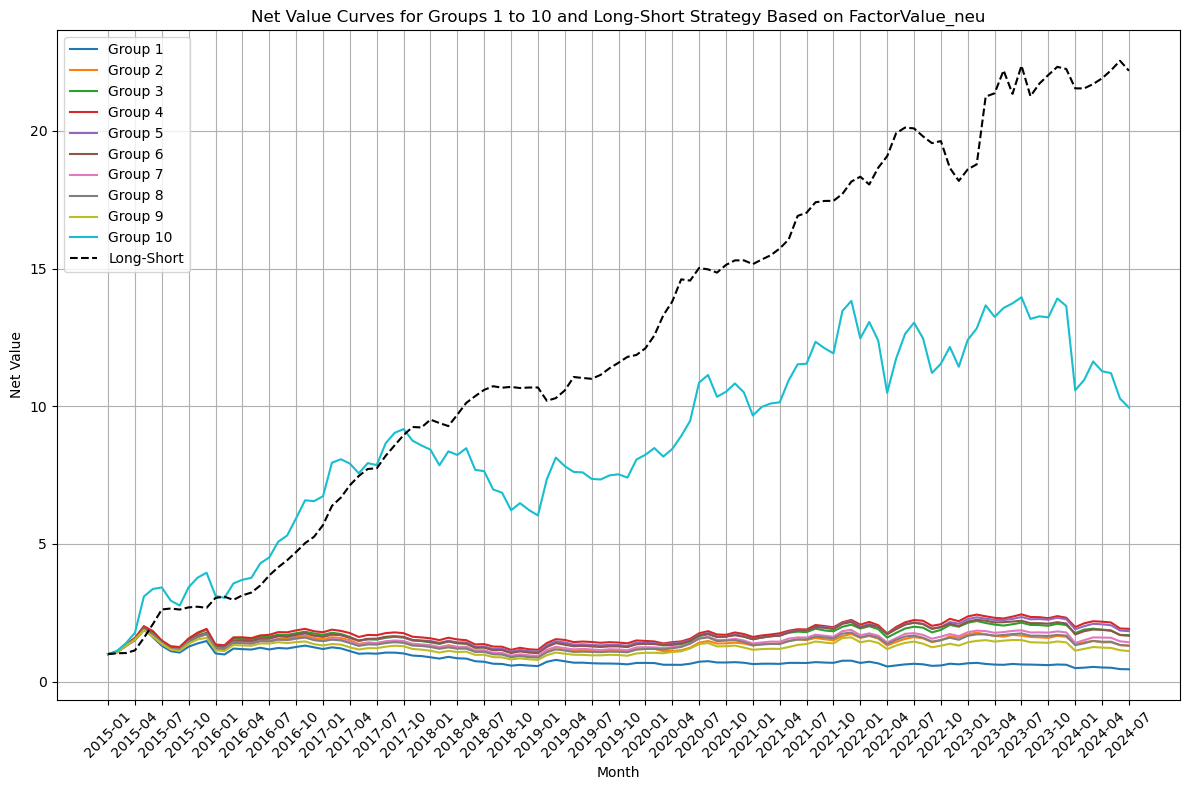

Annual Return: 38.57%
Annual Volatility: 20.74%
Information Ratio: 1.86
Monthly Win Rate: 75.65%
Max Drawdown: -9.62%


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10812\2064835448.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_short_net_value['Return'] = long_short_net_value['NetValue'].pct_change()


In [8]:
# 对FactorValue_neu进行十分组多空对冲净值走势分析，绘制回测曲线并计算年化收益率等指标

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 如果分组序号与因子值呈相反关系，则需要将因子值取负，从而得到倒置的分组序号
# df_PT['FactorValue_neu'] = -df_PT['FactorValue_neu']

# 计算每支股票每天的收益率
df_PT['Return'] = df_PT['ClosePrice'] /  df_PT['PreClosePrice'] - 1

# 创建一个字典用于保存每组的净值
net_values = {i: pd.DataFrame(columns=['Month', 'NetValue']) for i in range(1, 11)}
long_short_net_value = pd.DataFrame(columns=['Month', 'NetValue'])

# 自动分析回测区间的开始和结束日期
df_PT['TradeDay'] = pd.to_datetime(df_PT['TradeDay'])
start_date = df_PT['TradeDay'].min().strftime('%Y-%m')
end_date = df_PT['TradeDay'].max().strftime('%Y-%m')

# 初始化每组的净值为1
initial_net_value = 1
for i in range(1, 11):
    net_values[i] = pd.concat([net_values[i], pd.DataFrame({'Month': [start_date], 'NetValue': [initial_net_value]})])

long_short_net_value = pd.concat([long_short_net_value, pd.DataFrame({'Month': [start_date], 'NetValue': [initial_net_value]})])

# 计算每个月的末日
df_PT['Month'] = df_PT['TradeDay'].dt.to_period('M')
end_of_month = df_PT.groupby('Month')['TradeDay'].max().reset_index()

# 新增logReturn列
df_PT['logReturn'] = np.log(df_PT['Return'] + 1)

# 循环处理每个月的数据
for i in range(len(end_of_month) - 1):
    month_end_day = end_of_month.iloc[i]['TradeDay']
    next_month_end_day = end_of_month.iloc[i + 1]['TradeDay']

    # 获取该月最后一天的所有股票数据
    month_data = df_PT[df_PT['TradeDay'] == month_end_day].copy()
    
    # 对FactorValue_neu进行十分组
    month_data.loc[:, 'FactorValue_rank'] = pd.qcut(month_data['FactorValue_neu'], 10, labels=False) + 1

    returns = {}

    for group in range(1, 11):
        # 选出第x组的股票
        group_stocks = month_data[month_data['FactorValue_rank'] == group]['SecuCode'].values

        # 获取下个月这组股票的数据
        next_month_data = df_PT[(df_PT['TradeDay'] > month_end_day) & (df_PT['TradeDay'] <= next_month_end_day) & 
                                (df_PT['SecuCode'].isin(group_stocks))]

        # 计算每支股票的月收益率
        next_month_log_returns = next_month_data.groupby('SecuCode')['logReturn'].sum()
        next_month_returns = np.exp(next_month_log_returns) - 1

        # 计算第x组股票的平均月收益率
        avg_return = next_month_returns.mean()
        returns[group] = avg_return

        # 计算新的净值
        new_net_value = net_values[group].iloc[-1]['NetValue'] * (1 + avg_return)
        net_values[group] = pd.concat([net_values[group], pd.DataFrame({'Month': [str(next_month_end_day)[:7]], 'NetValue': [new_net_value]})])

    # 计算long-short策略的净值
    long_short_return = (1 + returns[10]) / (1 + returns[1]) - 1
    new_long_short_net_value = long_short_net_value.iloc[-1]['NetValue'] * (1 + long_short_return)
    long_short_net_value = pd.concat([long_short_net_value, pd.DataFrame({'Month': [str(next_month_end_day)[:7]], 'NetValue': [new_long_short_net_value]})])

# 绘制净值曲线
plt.figure(figsize=(12, 8))

for group in range(1, 11):
    plt.plot(net_values[group]['Month'], net_values[group]['NetValue'], linestyle='-', label=f'Group {group}')

plt.plot(long_short_net_value['Month'], long_short_net_value['NetValue'], linestyle='--', color='black', label='Long-Short')

plt.xlabel('Month')
plt.ylabel('Net Value')
plt.title('Net Value Curves for Groups 1 to 10 and Long-Short Strategy Based on FactorValue_neu')
plt.legend()

# 设置横轴每三个月标注一次
xticks = np.arange(0, len(long_short_net_value), step=3)
xlabels = [long_short_net_value['Month'].iloc[i] for i in xticks]
plt.xticks(ticks=xticks, labels=xlabels, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

# 计算long-short策略的绩效指标
long_short_net_value['Return'] = long_short_net_value['NetValue'].pct_change()

# 年化收益率
annual_return = (long_short_net_value['NetValue'].iloc[-1] / long_short_net_value['NetValue'].iloc[0]) ** (12 / (len(long_short_net_value) - 1)) - 1

# 年化波动率
annual_volatility = long_short_net_value['Return'].std() * np.sqrt(12)

# 信息比率
information_ratio = annual_return / annual_volatility

# 月度胜率
monthly_win_rate = (long_short_net_value['Return'] > 0).mean()

# 最大回撤率
rolling_max = long_short_net_value['NetValue'].cummax()
drawdown = (long_short_net_value['NetValue'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# 打印结果
print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")
print(f"Information Ratio: {information_ratio:.2f}")
print(f"Monthly Win Rate: {monthly_win_rate:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")

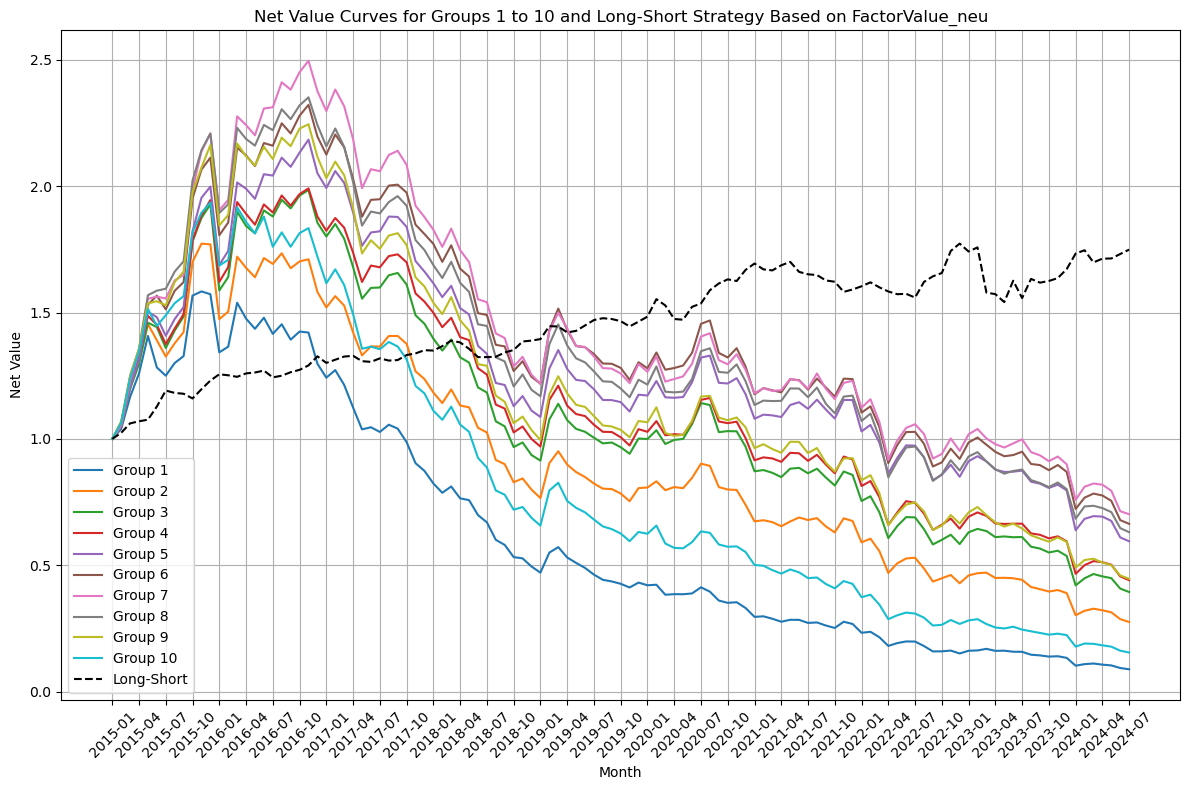

Annual Return: 6.06%
Annual Volatility: 7.38%
Information Ratio: 0.82
Monthly Win Rate: 61.74%
Max Drawdown: -13.06%


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17144\3313594563.py:107: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_short_net_value['Return'] = long_short_net_value['NetValue'].pct_change()


In [7]:
# 对FactorValue_neu进行十分组多空对冲净值走势分析，绘制回测曲线并计算年化收益率等指标
# 考虑了BlackList，月初交易时过滤掉不满足特定条件的股票
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 如果分组序号与因子值呈相反关系，则需要将因子值取负，从而得到倒置的分组序号
df_PT['FactorValue_neu'] = -df_PT['FactorValue_neu']

# 计算每支股票每天的收益率
df_PT['Return'] = df_PT['ClosePrice'] /  df_PT['PreClosePrice'] - 1

# 创建一个字典用于保存每组的净值
net_values = {i: pd.DataFrame(columns=['Month', 'NetValue']) for i in range(1, 11)}
long_short_net_value = pd.DataFrame(columns=['Month', 'NetValue'])

# 自动分析回测区间的开始和结束日期
df_PT['TradeDay'] = pd.to_datetime(df_PT['TradeDay'])
start_date = df_PT['TradeDay'].min().strftime('%Y-%m')
end_date = df_PT['TradeDay'].max().strftime('%Y-%m')

# 初始化每组的净值为1
initial_net_value = 1
for i in range(1, 11):
    net_values[i] = pd.concat([net_values[i], pd.DataFrame({'Month': [start_date], 'NetValue': [initial_net_value]})])

long_short_net_value = pd.concat([long_short_net_value, pd.DataFrame({'Month': [start_date], 'NetValue': [initial_net_value]})])

# 计算每个月的末日
df_PT['Month'] = df_PT['TradeDay'].dt.to_period('M')
end_of_month = df_PT.groupby('Month')['TradeDay'].max().reset_index()

# 新增logReturn列
df_PT['logReturn'] = np.log(df_PT['Return'] + 1)

# 循环处理每个月的数据
for i in range(len(end_of_month) - 1):
    month_end_day = end_of_month.iloc[i]['TradeDay']
    next_month_end_day = end_of_month.iloc[i + 1]['TradeDay']

    # 获取该月最后一天的所有股票数据
    month_data = df_PT[df_PT['TradeDay'] == month_end_day].copy()
    
    # 对FactorValue_neu进行十分组
    month_data.loc[:, 'FactorValue_rank'] = pd.qcut(month_data['FactorValue_neu'], 10, labels=False) + 1

    returns = {}

    for group in range(1, 11):
        # 选出第x组的股票
        group_stocks = month_data[month_data['FactorValue_rank'] == group]['SecuCode'].values

        # 获取下个月这组股票的数据
        next_month_data = df_PT[(df_PT['TradeDay'] > month_end_day) & (df_PT['TradeDay'] <= next_month_end_day) & 
                                (df_PT['SecuCode'].isin(group_stocks))]

        # 过滤条件：停牌、涨跌停、新股涨停、ST股、非标准审计意见、未停牌
        next_month_data = next_month_data[
            (next_month_data['IfSuspend'] == 0) &  # 未停牌
            (next_month_data['ClosePrice'] != next_month_data['SDqLimit']) &  # 未达到涨跌停
            (next_month_data['ClosePrice'] != next_month_data['SDqStopping']) &  # 未达到涨跌停
            (next_month_data['IfNewStockUpLtd'] == 0) &  # 非新股涨停
            (next_month_data['IfST'] == 0) &  # 非ST股
            (next_month_data['IfNonStandardAShareAuditOpinion'] == 0)  # 非非标准审计意见
        ]
        
        # 计算每支股票的月收益率
        next_month_log_returns = next_month_data.groupby('SecuCode')['logReturn'].sum()
        next_month_returns = np.exp(next_month_log_returns) - 1

        # 计算第x组股票的平均月收益率
        avg_return = next_month_returns.mean()
        returns[group] = avg_return

        # 计算新的净值
        new_net_value = net_values[group].iloc[-1]['NetValue'] * (1 + avg_return)
        net_values[group] = pd.concat([net_values[group], pd.DataFrame({'Month': [str(next_month_end_day)[:7]], 'NetValue': [new_net_value]})])

    # 计算long-short策略的净值
    long_short_return = (1 + returns[10]) / (1 + returns[1]) - 1
    new_long_short_net_value = long_short_net_value.iloc[-1]['NetValue'] * (1 + long_short_return)
    long_short_net_value = pd.concat([long_short_net_value, pd.DataFrame({'Month': [str(next_month_end_day)[:7]], 'NetValue': [new_long_short_net_value]})])

# 绘制净值曲线
plt.figure(figsize=(12, 8))

for group in range(1, 11):
    plt.plot(net_values[group]['Month'], net_values[group]['NetValue'], linestyle='-', label=f'Group {group}')

plt.plot(long_short_net_value['Month'], long_short_net_value['NetValue'], linestyle='--', color='black', label='Long-Short')

plt.xlabel('Month')
plt.ylabel('Net Value')
plt.title('Net Value Curves for Groups 1 to 10 and Long-Short Strategy Based on FactorValue_neu')
plt.legend()

# 设置横轴每三个月标注一次
xticks = np.arange(0, len(long_short_net_value), step=3)
xlabels = [long_short_net_value['Month'].iloc[i] for i in xticks]
plt.xticks(ticks=xticks, labels=xlabels, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

# 计算long-short策略的绩效指标
long_short_net_value['Return'] = long_short_net_value['NetValue'].pct_change()

# 年化收益率
annual_return = (long_short_net_value['NetValue'].iloc[-1] / long_short_net_value['NetValue'].iloc[0]) ** (12 / (len(long_short_net_value) - 1)) - 1

# 年化波动率
annual_volatility = long_short_net_value['Return'].std() * np.sqrt(12)

# 信息比率
information_ratio = annual_return / annual_volatility

# 月度胜率
monthly_win_rate = (long_short_net_value['Return'] > 0).mean()

# 最大回撤率
rolling_max = long_short_net_value['NetValue'].cummax()
drawdown = (long_short_net_value['NetValue'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# 打印结果
print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")
print(f"Information Ratio: {information_ratio:.2f}")
print(f"Monthly Win Rate: {monthly_win_rate:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")